In [1]:
import pandas as pd  
# DATASET_B_PATH_LINUX = '/media/chuang/LC/大学/第40期PRP/特征提取/DATASET-B.csv'
DATASET_B_PATH_WIN = 'D:/Working/PRP-2021/Data/Processed_Data/feature_analysis/Intergated-DATASET-D.csv'

# 读取数据文件 
data_in = pd.read_csv(DATASET_B_PATH_WIN).drop(['Unnamed: 0'], axis=1)
ROW_LIM_DOWN = -132
ROW_LIM_UP = -111
COL_LIM_DOWN = 24
COL_LIM_UP = 48

In [2]:
data_in

,row_id,col_id,time_id,aveSpeed,gridAcc,volume,speedStd,stopNum,date
0,-139.0,5.0,45.0,15.571961,-2.323410,1,0.000000,0.0,20161101
1,-139.0,5.0,48.0,10.679653,-0.098228,1,0.000000,0.0,20161101
2,-139.0,5.0,51.0,12.348424,0.018499,2,1.345171,0.0,20161101
3,-139.0,5.0,54.0,9.483641,0.109564,1,0.000000,0.0,20161101
4,-139.0,5.0,60.0,12.754410,-0.000014,1,0.000000,0.0,20161101
...,...,...,...,...,...,...,...,...,...
32887993,-1.0,52.0,299.0,11.870780,-0.933510,2,1.940621,0.0,20161130
32887994,-1.0,52.0,300.0,18.987620,-3.600893,1,0.000000,0.0,20161130
32887995,-1.0,52.0,301.0,12.517520,-1.124392,1,0.000000,0.0,20161130
32887996,-1.0,52.0,302.0,15.536704,-0.322319,1,0.000000,0.0,20161130


In [3]:
data = data_in.loc[(data_in.row_id >= ROW_LIM_DOWN)&(data_in.row_id <= ROW_LIM_UP) &(data_in.col_id >= COL_LIM_DOWN) & (data_in.col_id <= COL_LIM_UP)].copy()
# 转换数据类型
for c in ['row_id', 'col_id', 'time_id']:  
    data[c] = data[c].astype(int)
# 排序
data['date'] -= data['date'].min()
data['row_id'] -= data['row_id'].min()
data['col_id'] -= data['col_id'].min()
data['time_id'] -= data['time_id'].min()
data = data.sort_values(['date', 'row_id', 'col_id', 'time_id']).reset_index(drop=True)

In [4]:
def grid_recovery(df_, cols=[], lens=[]):
    df = df_.copy()
    lcols = len(cols)
    llens = len(lens)
    
    if lcols != llens: # 确保输入的网格名称和网格长度信息的长度一致
        raise ValueError(f'Lengths of cols ({lcols}) and lens ({llens}) mismatch.')
    
    recovery_df = None
    for c, l in zip(cols, lens):
        tmp_df = pd.DataFrame({c:range(l)})
        tmp_df['flag'] = True
        if recovery_df is None:
            recovery_df = tmp_df.copy()
        else:
            recovery_df = recovery_df.merge(tmp_df, 'left', 'flag')
    
    del recovery_df['flag']
    
    df = pd.merge(recovery_df, df, on=['date','row_id', 'col_id', 'time_id'])
    df = df.fillna(0)
    return df
    
NROWS = ROW_LIM_UP - ROW_LIM_DOWN + 1 # 空间网格行数  
NCOLS = COL_LIM_UP - COL_LIM_DOWN + 1 # 空间网格列数  
NTIME = data.time_id.max() - data.time_id.min() + 1 # 时间网格数  
NDATE = 30 # 日期网格数
data = grid_recovery(data, ['date', 'row_id', 'col_id', 'time_id'], [NDATE, NROWS, NCOLS, NTIME])  
for c in ['volume', 'stopNum']:  
    data[c] = data[c].astype(int) # 调整数据类型  

In [5]:
data['hourid'] = data['time_id'] // 6 # 合并时间网格  
data['new_rowid'] = data.row_id // 2 # 合并空间网格  
data['new_colid'] = data.col_id // 2  
speed = data.groupby( # 计算合并网格后各网格的流量  
    ['date', 'new_rowid', 'new_colid', 'hourid']).aveSpeed.sum().reset_index()  
speed.columns = ['date', 'row_id', 'col_id', 'hourid', 'gridSpeed']  

In [6]:
data['seqid'] = data.date * 144 + data.time_id  
core_data = data.loc[    
    data.new_rowid.eq(10) & data.new_colid.eq(10)    
].reset_index(drop=True) # 提取待预测数据    
ts = core_data.groupby(['seqid']).agg({    
    'volume': 'sum',    
    'aveSpeed': 'mean',    
    'gridAcc': 'mean',    
    'speedStd': 'mean',    
    'hourid': 'mean',    
    'date': 'mean',    
    'time_id': 'mean'    
}).reset_index() # 统计各项特征，建立时间序列

In [7]:
TIME_UNIT = data.groupby('hourid').size().count() # 每个小时里所包含的hourid的数量
from math import ceil

In [8]:
from sklearn.preprocessing import MinMaxScaler    
train_ts = ts[:-5*144].reset_index(drop=True)[[    
    'volume', 'aveSpeed', 'gridAcc', 'speedStd', 'hourid']] # 提取训练集序列    
test_ts = ts[-5*144:].reset_index(drop=True)[[    
    'volume', 'aveSpeed', 'gridAcc', 'speedStd', 'hourid']] # 提取测试集序列    
y_true_test = test_ts.values   # 测试集预测值真值    
scaler = MinMaxScaler()     # 初始化归一化工具    
scaler.fit(train_ts.values) # 读取数据最值信息    
train_ts = pd.DataFrame(scaler.transform(train_ts), columns=train_ts.columns) # 归一化训练集    
test_ts = pd.DataFrame(scaler.transform(test_ts), columns=test_ts.columns)    # 归一化测试集    

MinMaxScaler()

<AxesSubplot:ylabel='volume'>

<AxesSubplot:ylabel='volume'>

<AxesSubplot:ylabel='aveSpeed'>

<AxesSubplot:ylabel='aveSpeed'>

<AxesSubplot:ylabel='gridAcc'>

<AxesSubplot:ylabel='gridAcc'>

(-1.0, 2.0)

<AxesSubplot:ylabel='speedStd'>

<AxesSubplot:ylabel='speedStd'>

(-1.0, 11.0)

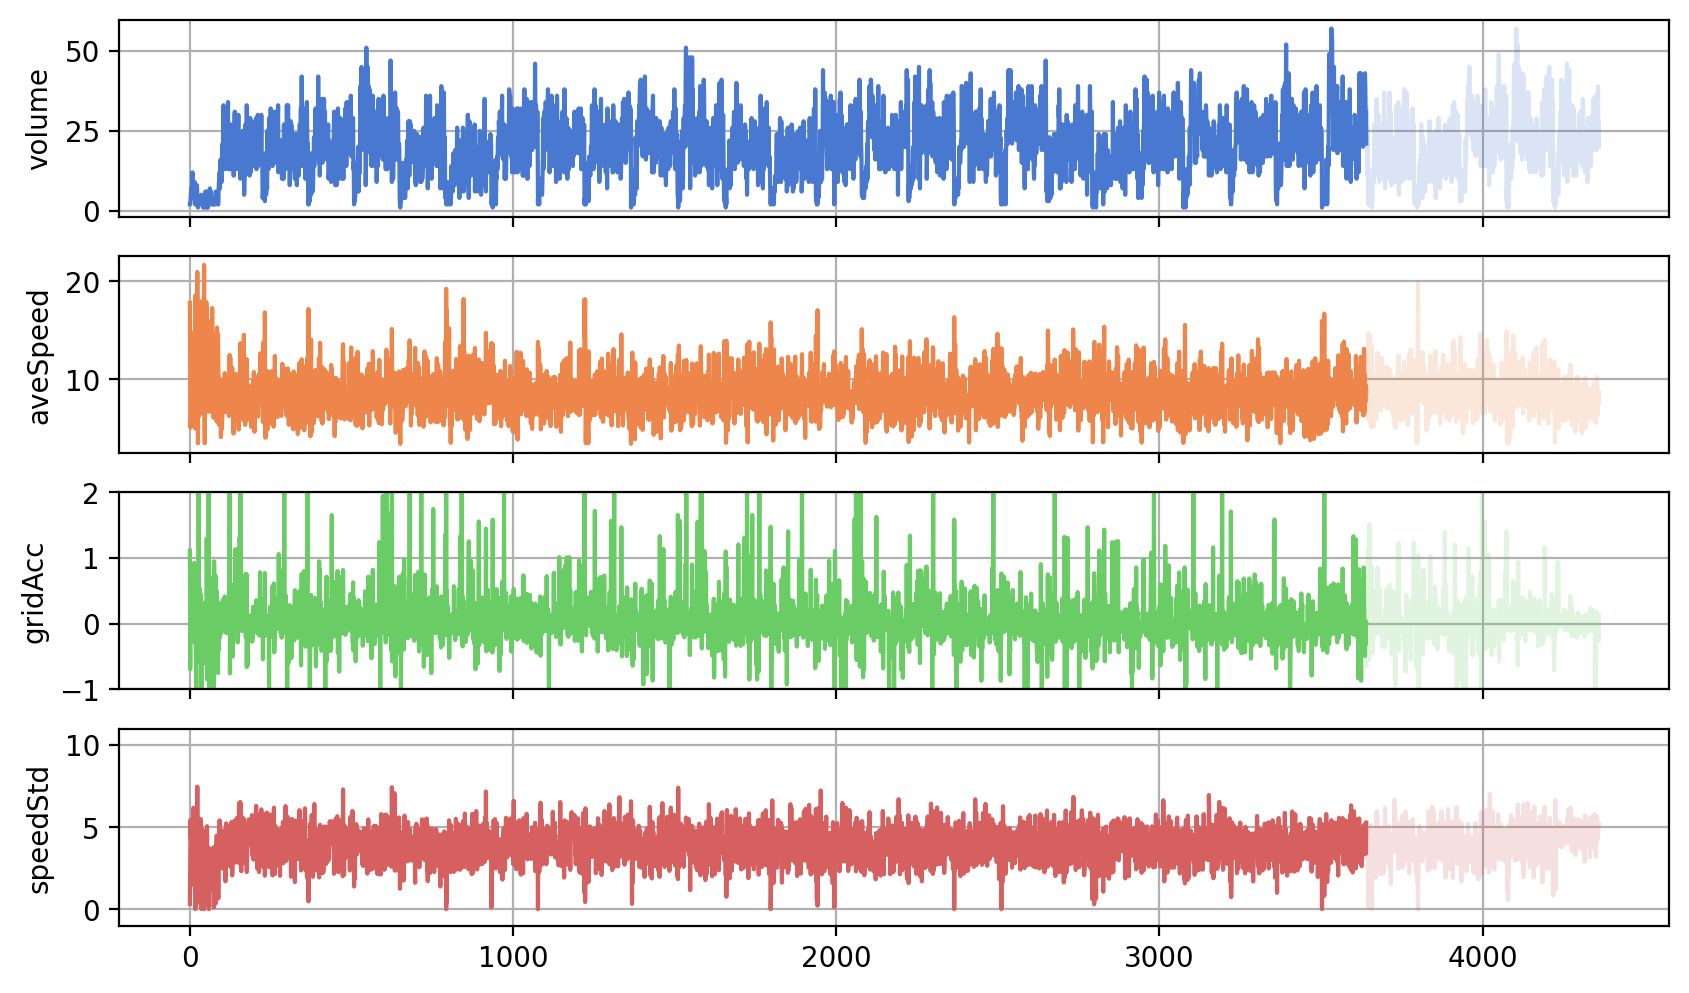

In [9]:
import matplotlib.pyplot as plt  
import seaborn as sns  
fig,ax = plt.subplots(4, 1, figsize=(10, 6), dpi=200, sharex=True)
for idx, (f, c) in enumerate(zip(['volume', 'aveSpeed', 'gridAcc', 'speedStd'], sns.color_palette('muted'))):
    sns.lineplot(x=ts[:-5*144].index, y=f, data=ts[:-5*144], color=c, ax=ax[idx])
    sns.lineplot(x=ts[-5*144:].index, y=f, data=ts[-5*144:], ax=ax[idx], color=c, alpha=0.2)
    ax[idx].grid()
    if idx == 2:
        ax[idx].set_ylim(-1, 2)
    elif idx == 3:
        ax[idx].set_ylim(-1, 11)

<Figure size 1800x1200 with 0 Axes>

<AxesSubplot:xlabel='col_id', ylabel='row_id'>

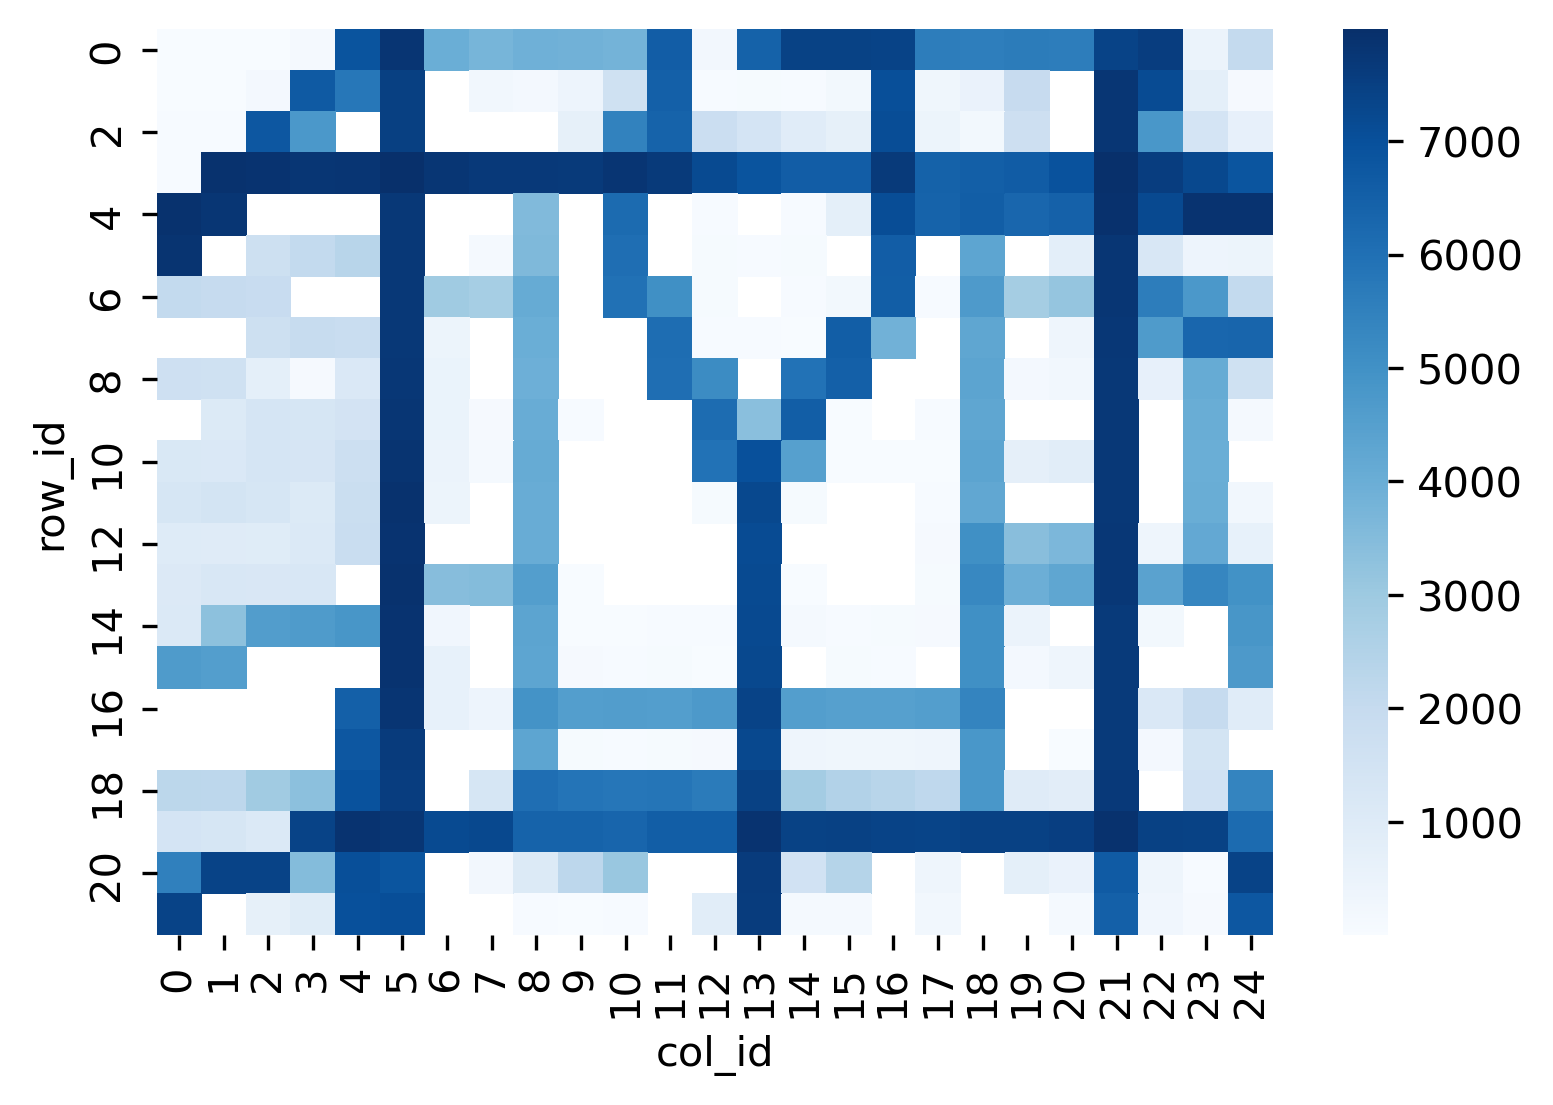

In [10]:
plt.figure(dpi=300)
sns.heatmap(data.groupby(['row_id', 'col_id']).size().reset_index(name='volume').pivot_table('volume', 'row_id', 'col_id'), cmap='Blues')
plt.show()

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split  
# 将时间序列预测转换为监督学习问题. 
def ts_to_supervise(ts, window, forecast):  
    """ 
    ts: 原始时间序列 
    window: 输入时间步数量 
    forecast: 输入时间步数量 
    """  
    past = []   # 存储输入的时间序列值  
    future = [] # 存储输出的时间序列值  
    for i in range(len(ts) - window - forecast + 1):  
        past.append(ts[i:i+window])  
        future.append(ts[i+window:i+window+forecast])  
    return np.stack(past), np.stack(future)  
    
ts_x, ts_y = ts_to_supervise(pd.concat([train_ts, test_ts]).values, 7*144, 1)  
train_X, test_X, train_y, test_y = train_test_split(    
    ts_x, ts_y, test_size=len(test_ts), shuffle=False) # 测试集划分 

In [12]:
test_ts

,volume,aveSpeed,gridAcc,speedStd,hourid
0,0.375000,0.302297,0.174101,0.419778,0.727273
1,0.553571,0.383237,0.200243,0.425905,0.727273
2,0.178571,0.137964,0.215075,0.506600,0.727273
3,0.321429,0.314851,0.208612,0.580379,1.000000
4,0.446429,0.276318,0.197596,0.634478,1.000000
...,...,...,...,...,...
715,0.446429,0.163540,0.197619,0.585353,1.000000
716,0.678571,0.171344,0.206226,0.600515,1.000000
717,0.339286,0.257842,0.190516,0.696642,1.000000
718,0.482143,0.295405,0.205436,0.688183,1.000000


In [13]:
# 建立模型
import tensorflow as tf  
from tensorflow.keras.models import Model  
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional  
# 设定随机种子  
SEED = 233  
np.random.seed(SEED)  
tf.random.set_seed(SEED)  
# 循环神经网络模型
def rnn_model(input_shape):  
    inputs = Input(shape=input_shape)  
    x = LSTM(8)(inputs)  
    x = Dense(8)(x)  
    x = Dense(1)(x)  
    model = Model(inputs=inputs, outputs=x) # 建立模型  
    return model  
model = rnn_model(train_X.shape[1:]) # 实例化模型 

In [14]:
#模型训练
from tensorflow.keras import optimizers  
from tensorflow.keras.callbacks import EarlyStopping  
batch_size = 16 # 每一训练批次的样本数量  
epochs = 30     # 最大训练轮数  
opt = optimizers.Adam(learning_rate=0.001) # 优化器  
model.compile(loss='mse',  
              optimizer=opt,  
              metrics=['mae', 'mse'])  
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20) # 早停策略  
history = model.fit(  
    train_X, train_y[..., 0],  
    batch_size=batch_size,  
    epochs=epochs,  
    validation_split=0.15, # 验证集比例  
    use_multiprocessing=True, # 使用多线程  
    callbacks=[early_stopping]) # 训练模型  

Epoch 1/30
140/140 [==============================] - 27s 183ms/step - loss: 0.0569 - mae: 0.1737 - mse: 0.0569 - val_loss: 0.0341 - val_mae: 0.1404 - val_mse: 0.0341
Epoch 2/30
140/140 [==============================] - 32s 229ms/step - loss: 0.0223 - mae: 0.1185 - mse: 0.0223 - val_loss: 0.0264 - val_mae: 0.1246 - val_mse: 0.0264
Epoch 3/30
140/140 [==============================] - 30s 215ms/step - loss: 0.0190 - mae: 0.1091 - mse: 0.0190 - val_loss: 0.0235 - val_mae: 0.1193 - val_mse: 0.0235
Epoch 4/30
140/140 [==============================] - 30s 213ms/step - loss: 0.0170 - mae: 0.1031 - mse: 0.0170 - val_loss: 0.0199 - val_mae: 0.1103 - val_mse: 0.0199
Epoch 5/30
140/140 [==============================] - 25s 177ms/step - loss: 0.0163 - mae: 0.1006 - mse: 0.0163 - val_loss: 0.0189 - val_mae: 0.1073 - val_mse: 0.0189
Epoch 6/30
140/140 [==============================] - 25s 176ms/step - loss: 0.0161 - mae: 0.0999 - mse: 0.0161 - val_loss: 0.0187 - val_mae: 0.1067 - val_mse: 0.018

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error  
pred_test = model.predict(test_X) # 预测测试集数据  
inv_test_ts = test_ts.copy()  
inv_test_ts.volume = pred_test  
y_hat_test = scaler.inverse_transform(inv_test_ts) # 还原归一化  
for i in range(np.shape(y_hat_test)[1]):
      print(mean_absolute_error(y_true_test[i], y_hat_test[i]),   
            mean_squared_error(y_true_test[i], y_hat_test[i]),   
            np.sqrt(mean_squared_error(y_true_test[i], y_hat_test[i])))
      print('\n')

0.5379552364349365 1.4469791820388422 1.2029044775204896


1.9300107479095459 18.624707435231823 4.315635229630955


2.5003520011901856 31.25880064927883 5.59095704233889


0.013135099411010775 0.0008626541826856737 0.02937097517423747


1.338459587097168 8.957370331461608 2.9928866218855683




In [22]:
np.shape(scaler.inverse_transform(inv_test_ts))


(720, 5)

<AxesSubplot:ylabel='volume'>

<AxesSubplot:ylabel='volume'>

<AxesSubplot:ylabel='volume'>

(-50.0, 4411.0)

Text(0, 0.5, 'volume')

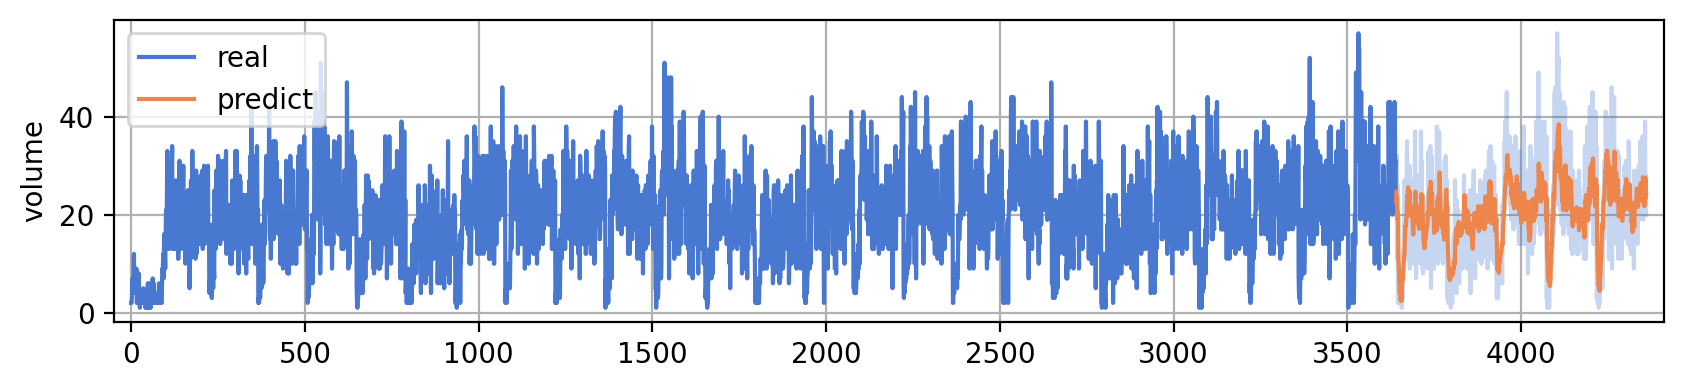

In [23]:
fig,ax = plt.subplots(1, 1, figsize=(10, 2), dpi=200, sharex=True)
c = sns.color_palette('muted')
sns.lineplot(x=ts[:-5*144].index, y='volume', data=ts[:-5*144], color=c[0], ax=ax, label='real')
sns.lineplot(x=ts[-5*144:].index, y='volume', data=ts[-5*144:], ax=ax, color=c[0], alpha=0.3)
sns.lineplot(x=ts[-5*144:].index, y=y_hat_test[:,0], ax=ax, color=c[1], label='predict')
ax.set_xlim(-50, len(ts) + 50)
ax.set_ylabel('volume')
ax.grid()
plt.show()

0


<AxesSubplot:ylabel='volume'>

<AxesSubplot:ylabel='volume'>

<AxesSubplot:ylabel='volume'>

1


<AxesSubplot:ylabel='aveSpeed'>

<AxesSubplot:ylabel='aveSpeed'>

<AxesSubplot:ylabel='aveSpeed'>

2


<AxesSubplot:ylabel='gridAcc'>

<AxesSubplot:ylabel='gridAcc'>

<AxesSubplot:ylabel='gridAcc'>

(-1.0, 2.0)

3


<AxesSubplot:ylabel='speedStd'>

<AxesSubplot:ylabel='speedStd'>

<AxesSubplot:ylabel='speedStd'>

(-1.0, 11.0)

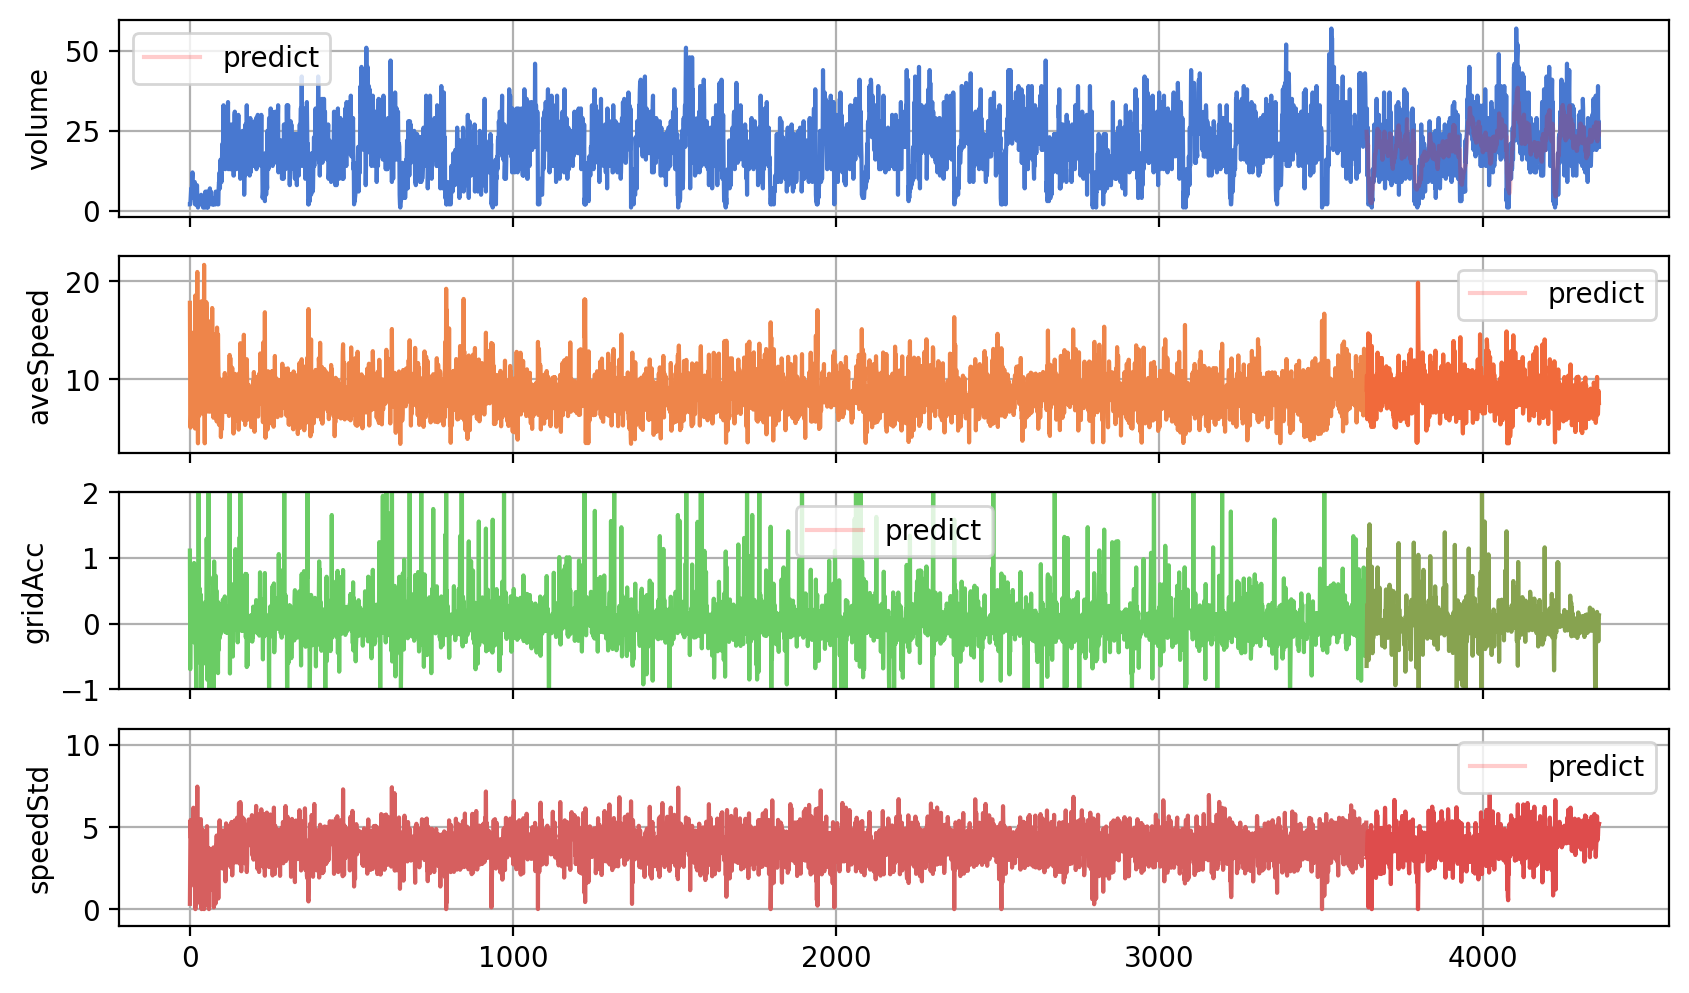

In [18]:
fig,ax = plt.subplots(4, 1, figsize=(10, 6), dpi=200, sharex=True)
for idx, (f, c) in enumerate(zip(['volume', 'aveSpeed', 'gridAcc', 'speedStd'], sns.color_palette('muted'))):
    print(idx)
    sns.lineplot(x=ts[:-5*144].index, y=f, data=ts[:-5*144], color=c, ax=ax[idx])
    sns.lineplot(x=ts[-5*144:].index, y=f, data=ts[-5*144:], ax=ax[idx], color=c)
    sns.lineplot(x=ts[-5*144:].index, y=y_hat_test[:,idx], ax=ax[idx], color='red', label='predict', alpha=0.2)
    ax[idx].grid()
    if idx == 2:
        ax[idx].set_ylim(-1, 2)
    elif idx == 3:
        ax[idx].set_ylim(-1, 11)
plt.show()

In [24]:
ts

,seqid,volume,aveSpeed,gridAcc,speedStd,hourid,date,time_id
0,1,2,17.797402,1.111240,0.323043,0.0,0.0,1.0
1,2,2,10.000062,-0.695345,2.956533,0.0,0.0,2.0
2,4,3,5.055911,0.148242,5.430058,0.0,0.0,4.0
3,5,5,6.368364,0.022224,4.339718,0.0,0.0,5.0
4,6,7,12.484396,0.622012,4.407610,1.0,0.0,6.0
...,...,...,...,...,...,...,...,...
4356,4441,26,6.383091,-0.107571,4.370426,44.0,29.0,265.0
4357,4442,39,6.525713,0.089373,4.483636,44.0,29.0,266.0
4358,4443,20,8.106538,-0.270090,5.201346,44.0,29.0,267.0
4359,4444,28,8.793046,0.071288,5.138189,44.0,29.0,268.0


In [25]:
np.shape(y_hat_test)

(720, 5)